# Data Science Challenge

Author: Reean Liao 

Date: July 2021

This is a question from hackerrank, which was given to me as a recruitment assessment for an Australian company.

In [1]:
# If you'd like to install packages that aren't installed by default, 
# uncomment the last two lines of this cell and replace <package list> with a list of your packages.
# This will ensure your notebook has all the dependencies and works everywhere

import sys
!{sys.executable} -m pip install <sklearn>

/bin/bash: -c: line 0: syntax error near unexpected token `newline'
/bin/bash: -c: line 0: `/opt/conda/bin/python -m pip install <sklearn>'


In [2]:
#Libraries
import pandas as pd
pd.set_option("display.max_columns", 101)
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score

## Data Description


Column | Description
:---|:---
`client_id` | Unique ID of the client called [unique key]
`age_bracket` | Age bracket of the contacted client (in years)
`job` | job type of the contacted client
`marital` | marital status of the contacted client
`education` | highest level of education done by the client
`has_housing_loan` | Whether the client has a house loan (binary: yes,no)
`has_personal_loan` | Whether the client has a personal loan (binary: yes,no)
`prev_call_duration` | last contact duration (value = 0 if the client has not been contacted ever)
`days_since_last_call` | number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
`num_contacts_prev` | number of contacts performed before this campaign and for this client (numeric)
`poutcome` | outcome of the previous marketing campaign (categorical: "failure","nonexistent","success")
`contact_date` | date at which contact was made with the client (YYYY-MM-DD)
`cpi` | standing consumer price index before the call (monthly indicator)
`subs_deposit` | has the client subscribed to a term deposit? (binary: 1,0) [dependent variable]

## Data Wrangling & Visualization

In [3]:
# Loading Train data
data_train = pd.read_csv("train.csv", parse_dates = ['contact_date'])
data_train.head()
print(data_train.shape)

(4000, 14)


There are 4000 rows and 14 columsn in the training dataset.

In [4]:
#Explore columns
data_train.columns

Index(['client_id', 'age_bracket', 'job', 'marital', 'education',
       'has_housing_loan', 'has_personal_loan', 'prev_call_duration',
       'days_since_last_call', 'num_contacts_prev', 'poutcome', 'contact_date',
       'cpi', 'subs_deposit'],
      dtype='object')

In [9]:
#Count missing value
data_train.isnull().sum(axis = 0)

client_id               0
age_bracket             0
job                     0
marital                 0
education               0
has_housing_loan        0
has_personal_loan       0
prev_call_duration      0
days_since_last_call    0
num_contacts_prev       0
poutcome                0
contact_date            0
cpi                     0
subs_deposit            0
dtype: int64

There doesn't seem to be missing values in the training dataset.

In [5]:
#Description
data_train.describe(percentiles = [0.05,0.5,0.95,0.975,0.99])

,client_id,prev_call_duration,days_since_last_call,num_contacts_prev,cpi,subs_deposit
count,4000.00000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,22430.64275,3871.142250,903.150750,0.272000,107.348378,0.397500
std,12052.91754,26080.549053,293.323535,0.643132,107.885469,0.489442
min,17.00000,2.000000,0.000000,0.000000,92.201000,0.000000
5%,2543.90000,50.000000,6.000000,0.000000,92.431000,0.000000
50%,23336.50000,237.000000,999.000000,0.000000,93.444000,0.000000
95%,39701.30000,1030.100000,999.000000,2.000000,94.465000,1.000000
97.5%,40633.02500,1269.050000,999.000000,2.000000,94.465000,1.000000
99%,40922.02000,157400.000000,999.000000,3.000000,946.010000,1.000000
max,41186.00000,419900.000000,999.000000,6.000000,947.670000,1.000000


From the above description of of the numeric columns (`client_id` here is treated as numeric value, will ignore this for the time being), we can gather that:
   * target variable `subs_deposit` has a mean of 0.4, in other words, target class is fairly balanced
   * `prev_call_duration` has some abnormally high numbers. This is supposed to be the call duration in the last contact, assuming the measure unit is seconds, having a number as high as 419900 doesn't make a lot of sense
   * `cpi` also has abnormally high numbers. This is supposed to be the Consumer Price Index. Having a CPI as high as 946 would suggest hyper inflation - given at least 97.5% of the records are under 100 (in a deflation economy), this feels wrong.
    
We will remove these rows from the model training.

In [16]:
#Remove outliers
data_train=data_train[(data_train['prev_call_duration']<=1440) & (data_train['cpi']<=100)]
#Keeping records where previous call is <= 1440 minutes (24 hours) and CPI is less than 100
data_train.shape

(3857, 14)

3857 records remain.

In [24]:
#Use pivot to tally up records
data_train[['client_id', 'days_since_last_call','num_contacts_prev']].pivot_table(index='days_since_last_call', 
                                                                     columns='num_contacts_prev', aggfunc='count')

client_id                                  
num_contacts_prev            0      1     2     3    4    5    6
days_since_last_call                                            
0                          NaN    3.0   NaN   2.0  NaN  NaN  NaN
1                          NaN    4.0   1.0   1.0  NaN  NaN  NaN
2                          NaN   11.0   2.0   1.0  NaN  NaN  NaN
3                          NaN   53.0  33.0  13.0  3.0  3.0  1.0
4                          NaN   14.0   7.0   6.0  NaN  NaN  NaN
5                          NaN    8.0   4.0   1.0  NaN  NaN  NaN
6                          NaN   56.0  33.0  18.0  2.0  1.0  NaN
7                          NaN    7.0   3.0   1.0  1.0  NaN  NaN
8                          NaN    2.0   1.0   1.0  NaN  NaN  NaN
9                          NaN    4.0   1.0   2.0  2.0  NaN  NaN
10                         NaN    8.0   2.0   1.0  1.0  NaN  NaN
11                         NaN    5.0   4.0   NaN  NaN  NaN  NaN
12                         NaN    5.0   1.0   NaN  NaN  NaN  NaN
13                         NaN    6.0   2.0   NaN  NaN  NaN  NaN
14                         NaN    2.0   1.0   NaN  NaN  NaN  NaN
15                         NaN    3.0   NaN   NaN  NaN  NaN  NaN
16                         NaN    1.0   1.0   NaN  NaN  NaN  NaN
17                         NaN    NaN   1.0   NaN  NaN  NaN  NaN
22                         NaN    1.0   NaN   NaN  NaN  NaN  NaN
25                         NaN    NaN   1.0   NaN  NaN  NaN  NaN
26                         NaN    1.0   NaN   NaN  NaN  NaN  NaN
999                     3127.0  341.0  33.0   3.0  NaN  NaN  NaN

Here, when there have been no previous contacts (`num_contacts_prev` =0), the days `days_since_last_call` is all 999, which is correct. But when there have been previous contact, we still see 377 (341+33+3) records with 999 as `days_since_last_call`. This is incorrect and would need further investigation to find out why this is the case, and to find out what the real values should be for these records. But for the purpose of this exercise, we will remove these records from training.  

In [28]:
#Remove outliers
data_train=data_train[~((data_train['days_since_last_call']==999) & (data_train['num_contacts_prev']!=0))]
#Removing records where days since last call is 999 but previous contacts is not 0
data_train.shape

(3480, 14)

3480 records remain.

## Feature Engineering

Since there is a mix of numeric and categorical features present. We will one-hot encode all the categorical variables.

In [29]:
#Separate features
numeric_features=data_train[['prev_call_duration', 'days_since_last_call', 'num_contacts_prev','cpi']]
cat_features=data_train[['age_bracket','job', 'marital','education', 'has_housing_loan', 'has_personal_loan', 'poutcome']]

In [32]:
y_train=data_train['subs_deposit']

In [30]:
#One hot encode
cat_features_encoded=pd.get_dummies(cat_features)

In [43]:
#Concat features together
x_train=pd.concat([cat_features_encoded, numeric_features], axis=1, sort=False)

In [45]:
x_train.shape

(3480, 34)

34 features will be used in modelling.

## Visualization, Modeling, Machine Learning

 Can you help Lending Bank to predict whether a client would subscribe to the term deposit and explain how different features affect that? Please explain your findings effectively to technical and non-technical audiences using comments and visualizations, if appropriate.
- **Build an optimized model that effectively solves the business problem.**
- **The model would be evaluated on the basis of F1 score.**
- **Read the test.csv file and prepare features for testing.**

### Select Base Model

In [57]:
#Set some baseline model to test
logit=LogisticRegression(random_state=20210717, solver='liblinear')
rforest=RandomForestClassifier(n_estimators=200, max_depth=3, random_state=20210717)
linearSVC=LinearSVC(random_state=20210717, max_iter=2000, dual=False)
gaussianBayes=GaussianNB()
gBoost=GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=20210717)

In [58]:
models = [logit, rforest,linearSVC, gaussianBayes, gBoost]

In [50]:
#Function to get cross validation result for a list of models
def get_model_cv(model_list, features, labels, scoring, cv,):

    #build a df for the cv results
    df_cv = pd.DataFrame(index=range(cv * len(model_list)))
    entries = []
    
    for model in model_list:
        model_name = model.__class__.__name__
        
        performance = cross_val_score(model, features, labels, scoring=scoring, cv=cv)
    
        for fold_idx, accuracy in enumerate(performance):
            entries.append((model_name, fold_idx, accuracy))
    
    df_cv = pd.DataFrame(entries, columns=['modelName', 'foldIndex', 'Performance'])
    
    return df_cv

In [59]:
df_model_cv=get_model_cv(model_list=models, features=x_train, labels=y_train, scoring='f1', cv=5)

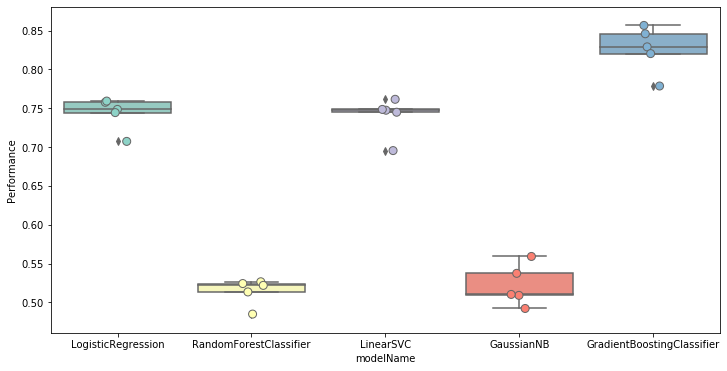

In [60]:
#Visualise CV results
plt.figure(figsize=(12,6))
sns.boxplot(x='modelName', y='Performance', data=df_model_cv, palette='Set3')
sns.stripplot(x='modelName', y='Performance', data=df_model_cv, 
              size=8, jitter=True, edgecolor="gray", linewidth=1, palette='Set3')
plt.show()

The best based model seems to be Gradient Boosting Classifier, with f1 score around 0.8 to 0.85. We will take this and move onto hyper parameter tuning.

### Hyper Parameter Tuning

In [63]:
#Grid search - just trying a few
parameters = {
    'learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    'n_estimators': [100, 150, 200, 250, 300],
    'max_depth': [3, 5, 7]
}

grid_search_tune = GridSearchCV(GradientBoostingClassifier(), parameters, scoring='f1', cv=5, n_jobs=2, verbose=3)
grid_search_tune.fit(x_train, y_train)

Fitting 5 folds for each of 105 candidates, totalling 525 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:   16.9s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:  2.3min
[Parallel(n_jobs=2)]: Done 284 tasks      | elapsed:  5.5min
[Parallel(n_jobs=2)]: Done 508 tasks      | elapsed:  9.6min
[Parallel(n_jobs=2)]: Done 525 out of 525 | elapsed: 10.2min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
                                                  presort=

In [65]:
print('The best set of the hyper parameters are:')
grid_search_tune.best_params_

The best set of the hyper parameters are:


{'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 250}

In [66]:
grid_search_tune.score(x_train, y_train)

0.9279210925644917

With the best hyper parameters, the training f1 score reaches 0.93.

In [67]:
#Build the optimised model
best_model=GradientBoostingClassifier(n_estimators=250, learning_rate=0.05, max_depth=5, random_state=20210717)
best_model.fit(x_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=250,
                           n_iter_no_change=None, presort='auto',
                           random_state=20210717, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)



**The bank wants to know what are the most important features for your model.  Can you tell them?**

> #### Task:
- **Visualize the top 20 features and their feature importance.**


In [71]:
#Get feature importance from the fitted model
importance = best_model.feature_importances_

top_n=20

feature_importance = pd.DataFrame({'importance':best_model.feature_importances_})    
feature_importance['feature'] = x_train.columns
feature_importance.sort_values(by='importance', ascending=False, inplace=True)
feature_importance = feature_importance.iloc[:top_n]

In [72]:
feature_importance

,importance,feature
30,0.449503,prev_call_duration
33,0.296892,cpi
32,0.075304,num_contacts_prev
31,0.043694,days_since_last_call
28,0.024268,poutcome_nonexistent
29,0.017932,poutcome_success
3,0.010471,age_bracket_60+
15,0.007312,education_bachelors
6,0.006457,job_other
12,0.006090,marital_married


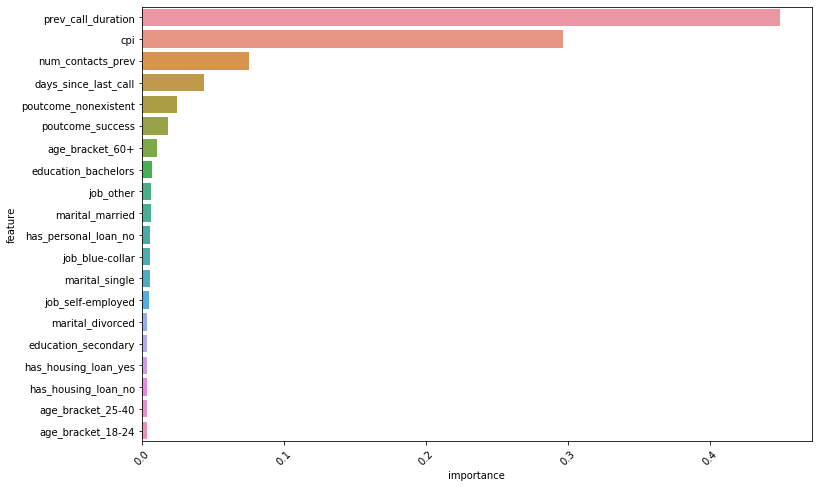

In [78]:
#Visualize
plt.figure(figsize=(12,8));
sns.barplot(y='feature', x='importance', data=feature_importance);
plt.xticks(rotation=45);

The most important feature is `prev_call_duration` followed by `cpi`, `num_contacts_prev` and `days_since_last_call`.

> #### Task:
- **Submit the predictions on the test dataset using your optimized model** <br/>
    For each record in the Test set (test.csv), you must predict the 'subs_deposit' variable (1/0). The 1/0 would depend on the **best F1 score**.
    You should submit a CSV file with test entries plus a header row. Your submission will show an error if you have extra columns beyond 'client_id' and 'subs_deposit' or extra rows.
The file (`submission.csv`) should have exactly 2 columns:
    - **client_id**
    - **subs_deposit** (contains 1/0)

In [10]:
#Loading Test data
data_test=pd.read_csv("test.csv",parse_dates = ['contact_date'])

print(data_test.shape)
data_test.head()

(1000, 13)


,client_id,age_bracket,job,marital,education,has_housing_loan,has_personal_loan,prev_call_duration,days_since_last_call,num_contacts_prev,poutcome,contact_date,cpi
0,19271,25-40,pink-collar,married,senior_secondary,no,no,176700,999,0,nonexistent,2018-03-07,93.918
1,36488,41-60,other,married,secondary,no,no,597,3,2,success,2018-01-11,947.670
2,2750,41-60,white-collar,married,secondary,yes,no,358,999,0,nonexistent,2018-01-05,93.994
3,4797,25-40,white-collar,single,senior_secondary,no,no,197,999,1,failure,2018-01-05,92.893
4,29971,41-60,technician,married,masters,yes,no,210,999,0,nonexistent,2018-01-08,92.201


In [11]:
data_test.isnull().sum(axis = 0)

client_id               0
age_bracket             0
job                     0
marital                 0
education               0
has_housing_loan        0
has_personal_loan       0
prev_call_duration      0
days_since_last_call    0
num_contacts_prev       0
poutcome                0
contact_date            0
cpi                     0
dtype: int64

1000 rows are present in the test set, no missing value is present.

In [12]:
#Description
data_test.describe(percentiles = [0.05,0.5,0.95,0.975,0.99])

,client_id,prev_call_duration,days_since_last_call,num_contacts_prev,cpi
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,21543.103000,3208.672000,906.659000,0.298000,110.547763
std,12435.531029,22406.857215,288.521402,0.680926,119.531699
min,37.000000,6.000000,0.000000,0.000000,92.201000
5%,1984.450000,51.950000,6.000000,0.000000,92.428400
50%,21723.000000,243.000000,999.000000,0.000000,93.444000
95%,39651.150000,1033.100000,999.000000,2.000000,94.465000
97.5%,40681.100000,1228.100000,999.000000,2.000000,94.465000
99%,40942.380000,144854.000000,999.000000,3.000000,946.026600
max,41115.000000,269200.000000,999.000000,5.000000,947.670000


As seen in the training set, the test set also suffer from errors in the `prev_call_duration` and `cpi` field. To make the predictions, we will manually impute these abnormally high values with the mean.

In [79]:
#Impute abnormally high values with mean
data_test['prev_call_duration'] = np.where(data_test['prev_call_duration'] >1440, 
                                           data_test['prev_call_duration'].mean(), data_test['prev_call_duration']) 
data_test['cpi'] = np.where(data_test['cpi'] >100, 
                                           data_test['cpi'].mean(), data_test['cpi']) 

In [80]:
#Separate features for the test data
numeric_features_test = data_test[['prev_call_duration', 'days_since_last_call', 'num_contacts_prev','cpi']]
cat_features_test = data_test[['age_bracket','job', 'marital','education', 'has_housing_loan', 'has_personal_loan', 'poutcome']]

In [81]:
#One hot encode for the test data
cat_features_encoded_test = pd.get_dummies(cat_features_test)

In [82]:
#Concat features together for the test data
x_test = pd.concat([cat_features_encoded_test, numeric_features_test], axis=1, sort=False)

In [88]:
#Get prediection from best model and append to test data
prediction = pd.DataFrame({'subs_deposit':best_model.predict(x_test)})
data_sub = pd.concat([data_test, prediction], axis=1, sort=False)

In [90]:
#Submission
data_sub[['client_id','subs_deposit']].to_csv('submissions.csv',index=False)

## Side Note

Given CPI is less than 100, the economy is likely in a declining environment with deflation as one of the symptoms. During deflation, the demand for spending and lending will drop. Since the bank's end goal is to use the deposit to fund lending, it's important to forecast lending demand first, and monitor the capital utilisation rate. It'll be quite costly to the bank if it's able to attract a lot of deposit, but not much lending demand.